# Zoom Backlighting Experiment Notebook

## Questions/Notes

Questions:
<ul>
    <li> Should do some sort of spatiotemporal processing maybe?? (See motion 2 compact slides)
    <li> Trouble with measuring backlit ness
    <li> When to do the processing? Only when we detect that our image is backlit? 
    <li> Haar gives a square, do we want whole outline of person?
    <li> Haar doesn’t work with rotated heads (should prob just find another method for this)
</ul>

Notes:

## Resources

### Used
- [The Haar Cascade tutorial](https://learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/). Also includes some info about non-haar cascade face detection models.

### Might Use
- Yale Dataset with differing levels of backlit people's faces: [website](http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html). Has illumination conditions labeled, etc.
- Some resources for doing low light image enhancement: [Github](https://github.com/dawnlh/awesome-low-light-image-enhancement)
    - Other ways to do facial detection
        - [Recurrent Exposure Generation for Low-Light Face Detection
](https://arxiv.org/abs/2007.10963)
        - [HLA Face]( https://daooshee.github.io/HLA-Face-Website/)
        - [Single-Stage_Face_Detection_Under_Extremely_Low-Light_Conditions](https://openaccess.thecvf.com/content/ICCV2021W/RLQ/papers/Yu_Single-Stage_Face_Detection_Under_Extremely_Low-Light_Conditions_ICCVW_2021_paper.pdf)
    - Benchmark? [WIDER FACE benchmark](http://shuoyang1213.me/WIDERFACE/)
- Google stuff about doing directional light enhancement on photos. [Blog post](https://ai.googleblog.com/2020/12/portrait-light-enhancing-portrait.html) and [facial detection keypoint model documentation](https://google.github.io/mediapipe/solutions/face_mesh.html)
</ul>

## Setup

First make necessary imports. Make sure we run the jupyter notebook instance using the (base) environment, else some of these packages won't be installed yet. 

In [1]:
import numpy as np
from PIL import Image
import pylab
from glob import glob
import cv2
from icecream import ic
import os
import unittest

%matplotlib inline
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (12, 10)

Here's our images! We load them into a dictionary for future reference.

In [43]:
imgFolder = "images"
imgDict = {}
for filename in os.listdir(imgFolder):
    imgDict[filename] = np.array(Image.open(imgFolder + '/' + filename))
[key for key in imgDict.keys()] # print out the keys for future reference

['badBrightnessPhoto.png',
 'well-lit1.jpg',
 'noAdjustLowLight.png',
 'manualAdjustLowLightMax.png',
 'adjustForLowLightManualHalfway.png',
 'autoAdjustForLowLight.png']

Here's the first image we are looking at, which is just a typical backlit image

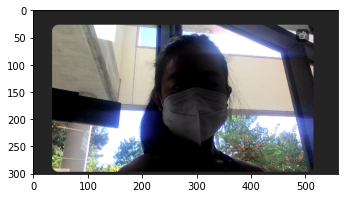

In [44]:
plt.subplot(2,2,1)
plt.imshow(imgDict['badBrightnessPhoto.png'])

Here's the other four images, all of which have differing levels of backlit adjustment from Zoom's own algorithms.

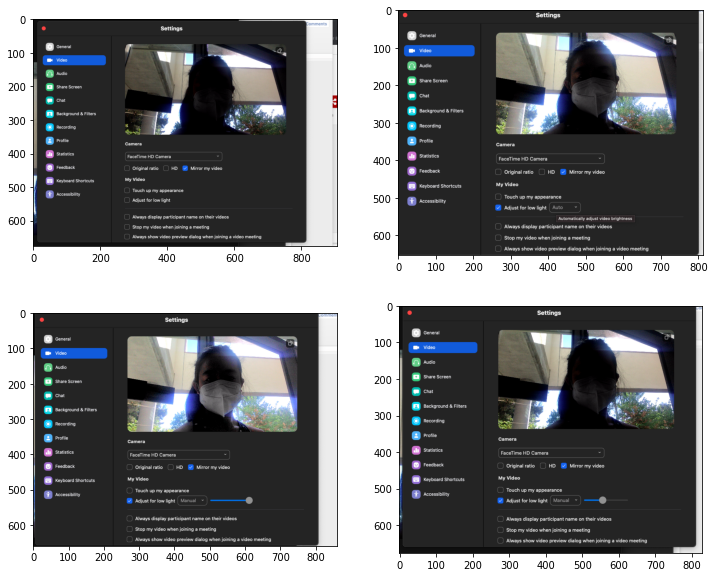

In [45]:

plt.subplot(2,2,1)
plt.imshow(imgDict["noAdjustLowLight.png"])

plt.subplot(2,2,2)
plt.imshow(imgDict['autoAdjustForLowLight.png'])

plt.subplot(2,2,3)
plt.imshow(imgDict['manualAdjustLowLightMax.png'])

plt.subplot(2,2,4)
plt.imshow(imgDict['adjustForLowLightManualHalfway.png'])

## Face detection (Haar)

FaceDetect holds methods to detect the face from a picture or video stream. I wrote this class by adapting it from some previous work I did with Haar cascades (scroll to the bottom of [this file](https://github.com/tennisoctocat/push-up-poker/blob/main/training/FacialFeatures.ipynb), which I had previously adapted from this [tutorial](https://learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/).


In [52]:
"""FaceDetect holds methods to detect the face from a picture or video stream."""

class FaceDetect():
	def __init__(self):
		self.faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
		self.faces = [] # faces in form of x, y, width, height
		self.shapeOfLastDetectedImg = (0, 0)

	# Public method, lets you use whatever implmentation you want. 
	def getNewFrame(self, img, timeStep=0):
		"""Gets the new frame to show on the screen. Called by external classes, etc."""
		# Always run detection of img's shape changed. Otherwise we might get
		# an index out of bounds exception for when the old faces run off the edges 
			# of the new frame.
        # Timestep included for video processing (only do processing every 20 timesteps)
		if timeStep % 20 == 0 or np.array(img).shape != self.shapeOfLastDetectedImg:
			self._get_faces_with_haar(img)
			return self._draw_faces(img)
		return self._draw_faces(img)

	def _draw_faces(self, img):
		"""Draws a white box for every face in the self.faces array"""
        
		if self.faces is None:
			return img
        
		numChannels = img.shape[-1]
		for face in self.faces:
			x,y,w,h = face
			img[y: y + h, x] = [255] * numChannels # Left off here, need to draw the actual bounding boxes. 
			img[y: y + h, x + w] = [255] * numChannels# Left off here, need to draw the actual bounding boxes. 
			img[y, x:x + w] = [255] * numChannels
			img[y + h, x:x + w] = [255] * numChannels
		return img

	def _get_faces_with_haar(self, img):
		"""Uses haar cascades to detect faces and save them in the self.faces array"""
		if img is None:
			return 

		img = np.array(img)

		# Detect faces
		self.faces = self.faceCascade.detectMultiScale(img, minNeighbors=3, minSize=(int(img.shape[0]/10), int(img.shape[0]/10)))
		self.shapeOfLastDetectedImg = img.shape

		# Print so we know what is happening
		if len(self.faces) > 1:
			print("faces greater than 1 ")
		elif len(self.faces) == 0:
			print("no face found ")




Create a `FaceDetect` instance in order to detect and display images with bounding boxes for the faces.

In [53]:
faceDetect = FaceDetect()

We note that Haar cascades doesn't do so well when I'm wearing a mask and it is dark.

no face found 


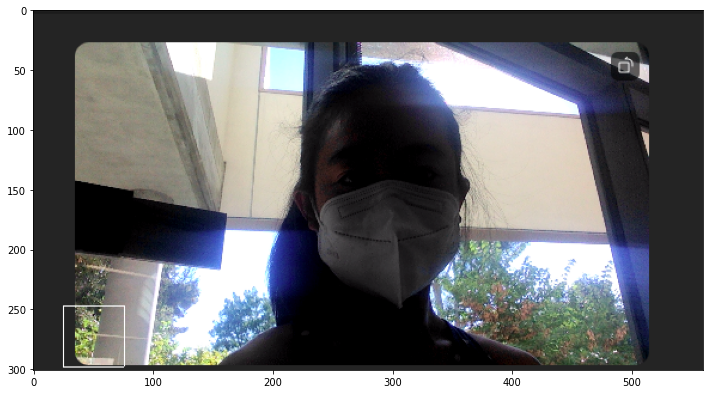

In [54]:
badBrightnessFacesImg = faceDetect.getNewFrame(imgDict['badBrightnessPhoto.png'])
plt.imshow(badBrightnessFacesImg)

But, it works just fine on normal photos.

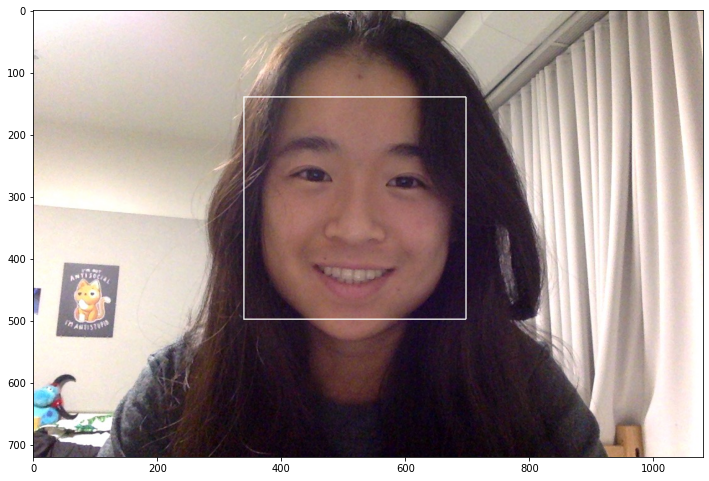

In [55]:
normalFacesImg = faceDetect.getNewFrame(imgDict['well-lit1.jpg'])
plt.imshow(normalFacesImg)